In [5]:
import pandas as pd
import numpy as np
np.random.seed(701)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import duckdb

In [6]:
conn = duckdb.connect(database='embeddings.db')

# Perform K-means Clustering on the critic and audience data separately, then perform clustering on the data together.


In [3]:
from sklearn.cluster import KMeans

In [7]:
data = conn.execute("SELECT Viewer, Movie, Sentiment, ID, EmbeddingValue FROM embeddings384").fetchdf()
data

,Viewer,Movie,Sentiment,ID,EmbeddingValue
0,Audience,war_of_the_worlds,Negative,102401,"[-0.09393362, 0.14137916, -0.012300838, -0.044..."
1,Audience,war_of_the_worlds,Negative,102402,"[-0.08732375, 0.12564541, -0.017482644, -0.045..."
2,Audience,war_of_the_worlds,Negative,102403,"[-0.09374756, 0.1473561, 0.008707689, -0.04181..."
3,Audience,war_of_the_worlds,Negative,102404,"[-0.07822682, 0.13861911, 0.009358808, -0.0535..."
4,Audience,war_of_the_worlds,Negative,102406,"[-0.07931607, 0.11045076, 0.011352594, -0.0490..."
...,...,...,...,...,...
253898,Audience,war_of_the_worlds,Negative,101576,"[-0.09388082, 0.12330725, 0.0031593172, -0.048..."
253899,Audience,war_of_the_worlds,Negative,101901,"[-0.106644556, 0.1439313, 0.0016598947, -0.040..."
253900,Audience,war_of_the_worlds,Negative,101978,"[-0.0961653, 0.14749579, -0.0041379724, -0.044..."
253901,Audience,the_northman,Negative,100866,"[-0.06841529, 0.10787069, 0.008072913, -0.0475..."


In [40]:
critic_count = data.groupby('Viewer').count().sort_values('Movie', ascending=False)
critic_count

,Movie,Sentiment,ID,EmbeddingValue
Viewer,,,,
Audience,250284,250284,250284,250284
Critic,3619,3619,3619,3619


## Together

In [15]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(X=np.array(data['EmbeddingValue'].tolist()))

/home/ryangorman/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
# Test the clustering's accuracy
correct = 0
for i in range(len(data)):
    sample = np.array(data['EmbeddingValue'][i]).reshape(1, -1).astype(np.float32)
    pred = kmeans.predict(sample)[0]
    if pred == data['Sentiment'][i]:
        correct += 1
print(correct/len(data))

0.0


## Critic

## Audience

# Analyze clusters to identify patterns and themes.
# Split critic review datasets into train, test, and validation sets at 70%, 15%, and 15% rate. Do the same for audience reviews.


In [12]:
# Split critic review datasets into train, test, and validation sets at 70%, 15%, and 15% rate. Do the same for audience reviews.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
critic_data = data[data['Viewer'] == 'Critic']
audience_data = data[data['Viewer'] == 'Audience']

critic_train, critic_test = train_test_split(critic_data, test_size=0.3)
critic_test, critic_val = train_test_split(critic_test, test_size=0.5)

audience_train, audience_test = train_test_split(audience_data, test_size=0.3)
audience_test, audience_val = train_test_split(audience_test, test_size=0.5)

train = pd.concat([critic_train, audience_train])
test = pd.concat([critic_test, audience_test])
val = pd.concat([critic_val, audience_val])


In [55]:
np.array(train['EmbeddingValue'].tolist()).shape

(177731, 384)

# Train two of each model (classification, support vector machine, and SOLAR). One model is for critic reviews, one is for audience reviews

In [54]:
# RF model for critic reviews

depths = [1, 2, 3, 5, 7]

combined_accuracies = {}
for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=depth)
    rf.fit(
        X=np.array(train['EmbeddingValue'].tolist()),
        y=train['Sentiment']
    )
    pred = rf.predict(np.array(test['EmbeddingValue'].tolist()))
    acc = accuracy_score(test['Sentiment'], pred)
    combined_accuracies[depth] = acc
    print(f'Combined Data, Max Depth of {depth}: {acc}')

Combined Data, Max Depth of 1: 0.7041432547392743
Combined Data, Max Depth of 2: 0.7969857690489944
Combined Data, Max Depth of 3: 0.8406501076511054
Combined Data, Max Depth of 5: 0.8933466365593656
Combined Data, Max Depth of 7: 0.9287664758703986


In [55]:
critic_accuracies = {}
for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=depth)
    rf.fit(
        X=np.array(critic_train['EmbeddingValue'].tolist()),
        y=critic_train['Sentiment']
    )
    pred = rf.predict(np.array(critic_test['EmbeddingValue'].tolist()))
    acc = accuracy_score(critic_test['Sentiment'], pred)
    print(f'Critic Data, Max Depth of {depth}: {acc}')
    critic_accuracies[depth] = acc

Critic Data, Max Depth of 1: 0.7532228360957642
Critic Data, Max Depth of 2: 0.8158379373848987
Critic Data, Max Depth of 3: 0.8250460405156538
Critic Data, Max Depth of 5: 0.8895027624309392
Critic Data, Max Depth of 7: 0.9226519337016574


In [56]:
audience_accuracies = {}
for depth in depths:
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=depth)
    rf.fit(
        X=np.array(audience_train['EmbeddingValue'].tolist()),
        y=audience_train['Sentiment']
    )
    pred = rf.predict(np.array(audience_test['EmbeddingValue'].tolist()))
    acc = accuracy_score(audience_test['Sentiment'], pred)
    print(f'Audience Data, Max Depth of {depth}: {acc}')
    audience_accuracies[depth] = acc

Audience Data, Max Depth of 1: 0.705271288922036
Audience Data, Max Depth of 2: 0.8064619236608689
Audience Data, Max Depth of 3: 0.8419412407106518
Audience Data, Max Depth of 5: 0.8980635537916523
Audience Data, Max Depth of 7: 0.9332765096023227


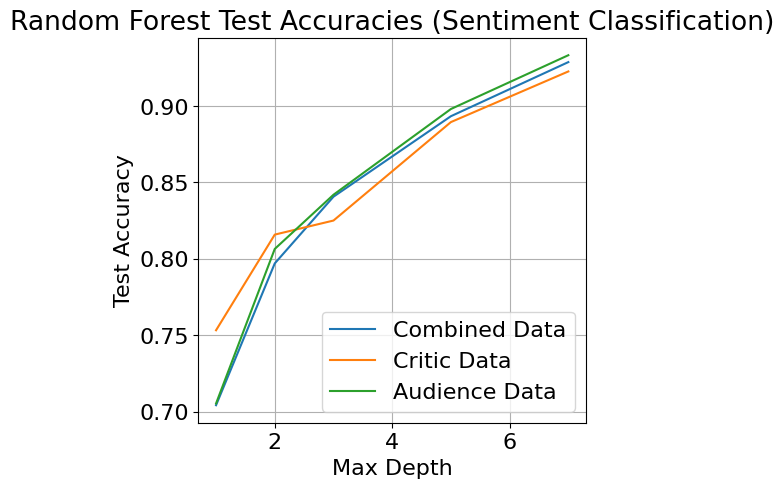

In [57]:
# Plot the accuracies
plt.figure(figsize=(5,5))
plt.plot(list(combined_accuracies.keys()), list(combined_accuracies.values()), label='Combined Data')
plt.plot(list(critic_accuracies.keys()), list(critic_accuracies.values()), label='Critic Data')
plt.plot(list(audience_accuracies.keys()), list(audience_accuracies.values()), label='Audience Data')
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy')
plt.legend()
plt.title('Random Forest Test Accuracies (Sentiment Classification)')
plt.grid()
plt.show()

In [10]:
# SVM. Scale the data first
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.array(train['EmbeddingValue'].tolist()))
train_scaled = scaler.transform(np.array(train['EmbeddingValue'].tolist()))
val_scaled = scaler.transform(np.array(val['EmbeddingValue'].tolist()))
test_scaled = scaler.transform(np.array(test['EmbeddingValue'].tolist()))

train_critic_scaled = scaler.transform(np.array(critic_train['EmbeddingValue'].tolist()))
val_critic_scaled = scaler.transform(np.array(critic_val['EmbeddingValue'].tolist()))
test_critic_scaled = scaler.transform(np.array(critic_test['EmbeddingValue'].tolist()))

train_audience_scaled = scaler.transform(np.array(audience_train['EmbeddingValue'].tolist()))
val_audience_scaled = scaler.transform(np.array(audience_val['EmbeddingValue'].tolist()))
test_audience_scaled = scaler.transform(np.array(audience_test['EmbeddingValue'].tolist()))

In [14]:
# Train SVM for combined data
sgd_accuracies = {}
sgd = SGDClassifier()
sgd.fit(train_scaled, train['Sentiment'])
pred = sgd.predict(test_scaled)
acc = accuracy_score(test['Sentiment'], pred)
print(f'Combined Data: {acc}')
sgd_accuracies['Combined'] = acc

Combined Data: 0.5648794832746941


In [17]:
sgd2 = SGDClassifier()
sgd2.fit(train_critic_scaled, critic_train['Sentiment'])
pred = sgd2.predict(test_critic_scaled)
acc = accuracy_score(critic_test['Sentiment'], pred)
print(f'Critic Data: {acc}')
sgd_accuracies['Critic'] = acc

Critic Data: 0.4990791896869245


In [18]:
# Train SVM for audience data
sgd3 = SGDClassifier()
sgd3.fit(train_audience_scaled, audience_train['Sentiment'])
pred = sgd3.predict(test_audience_scaled)
acc = accuracy_score(audience_test['Sentiment'], pred)
print(f'Audience Data: {acc}')
sgd_accuracies['Audience'] = acc

Audience Data: 0.5581067043123885


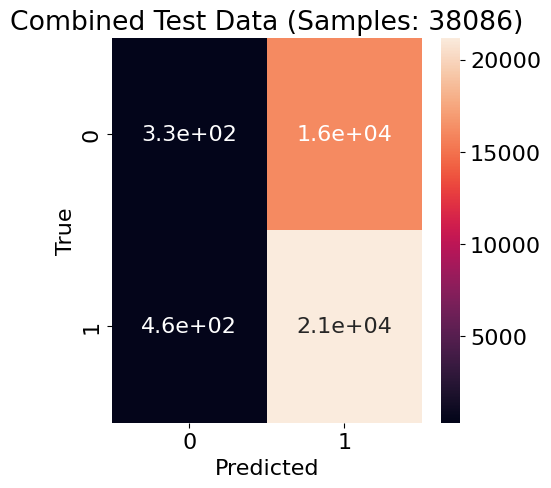

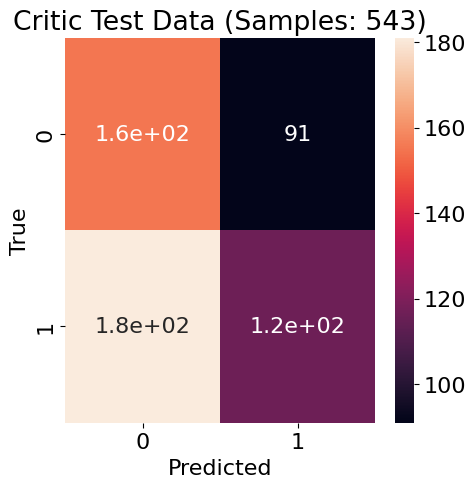

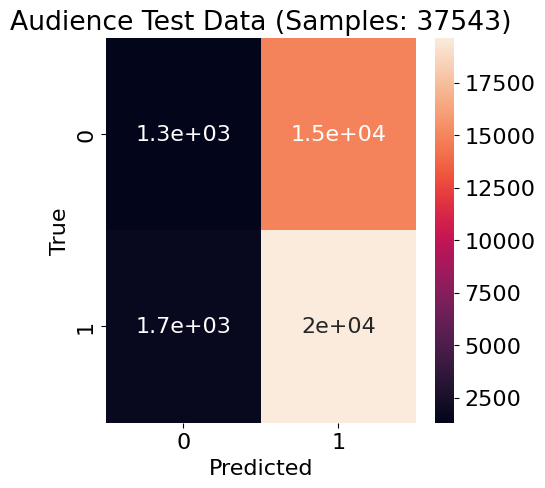

In [52]:
# Plot the confusion matrices for the SVM models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch import normal
# Make fonts larger
plt.rcParams.update({'font.size': 16})
# Combined Data
fig = plt.figure(figsize=(5, 5))
pred = sgd.predict(test_scaled)
cm = confusion_matrix(test['Sentiment'], pred)
sns.heatmap(cm, annot=True)

plt.title(f'Combined Test Data (Samples: {len(test)})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Critic Data
fig = plt.figure(figsize=(5, 5))
pred = sgd2.predict(test_critic_scaled)
cm = confusion_matrix(critic_test['Sentiment'], pred)
sns.heatmap(cm, annot=True)

plt.title(f'Critic Test Data (Samples: {len(critic_test)})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Audience Data
fig = plt.figure(figsize=(5, 5))
pred = sgd3.predict(test_audience_scaled)
cm = confusion_matrix(audience_test['Sentiment'], pred)
sns.heatmap(cm, annot=True)

plt.title(f'Audience Test Data (Samples: {len(audience_test)})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# BReak each subplot into a separate plot to render
